In [1]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import albumentations as A # image augmentation library for computer vision tasks 
from albumentations.pytorch import ToTensorV2


In [2]:
labels_path = "./rsna_heart_detection.csv"
labels =  pd.read_csv(labels_path)


In [3]:
class CardiacDataset(torch.utils.data.Dataset):

    def __init__(self, path_to_labels_csv, patients, root_path, augs):

        self.labels = pd.read_csv(path_to_labels_csv)
        self.patients = np.load(patients) # array with patient ID names
        self.root_path = Path(root_path)
        self.augment = augs # augmentation pipeline

    def __len__(self):
        """
        Returns the length of the dataset 
        """
        return len(self.patients)

    def __getitem__(self, idx):
        """
        Returns an image paired with the corresponding bounding box around the heart
        """
        # get patient data
        patient = self.patients[idx] # get data according to index
        data = self.labels[self.labels["name"] == patient]

        #extract bounding box coordinates 
        x_min = data["x0"].item() # left edge
        y_min = data["y0"].item() # top edge
        x_max = x_min + data["w"].item() # right edge
        y_max = y_min + data["h"].item() # bottom edge

        #Load image 
        file_path = self.root_path/patient
        img = np.load(f"{file_path}.npy").astype(np.float32) # Converts to float32 for NN processing

        # apply augmentations to both image and bounding box
        if self.augment:
            height , width = img.shape[:2] # image dimensions
            bboxes = [[x_min, y_min, x_max, y_max]]
            # Apply augmentations
            augmented = self.augment(
                image=img,
                bboxes=bboxes,
                class_labels=['heart']  # Albumentations needs class labels for bboxes

            )

            img = augmented['image']

            # Get the augmented bounding box
            if len(augmented['bboxes']) > 0:
                aug_bbox = augmented['bboxes'][0]  # Get first (and only) bbox
                bbox = [aug_bbox[0], aug_bbox[1], aug_bbox[2], aug_bbox[3]]
            else:
                # If bbox was cropped out, use original
                bbox = [x_min, y_min, x_max, y_max]
        else:
            bbox = [x_min, y_min, x_max, y_max]

        # Ensure image is numpy array and correct dtype
        #img = np.array(img, dtype=np.float32)
        
        # Normalize the image to a standard range for better NN training (mean and std dev computed in preprocessing file)
        img = (img - 0.494) / 0.252

        # Convert to tensor and add channel dimension for grayscale
        img = torch.tensor(img,dtype=torch.float32).unsqueeze(0)
        bbox = torch.tensor(bbox, dtype=torch.float32)

        return img, bbox
        
            

In [4]:
# create an augmentation object
seq = A.Compose([
    # Gamma/contrast adjustments
    A.OneOf([
        A.RandomGamma(gamma_limit=(80, 120), p=1.0), # Values are percentages: 80 = 0.8x gamma, 120 = 1.2x gamma
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=1.0),
    ], p=0.8),
    
    # Geometric transformations
    A.Affine(
        scale={'x': (0.8, 1.2), 'y': (0.8, 1.2)}, 
        rotate=(-10, 10),
        translate_px=(-10, 10),
        shear=(-5, 5),  # add slight shearing
        p=0.9
    ),
    
], bbox_params=A.BboxParams( # to track bounding boxes through transformations
    format='pascal_voc',
    label_fields=['class_labels']
))

In [5]:
# test the dataset:
labels_path = "./rsna_heart_detection.csv"
patients_path = "train_subjects.npy"
train_root = "Processed-Heart-Detection/train/"
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

tensor([ 80.4780,  55.9607, 178.2586, 176.6793])


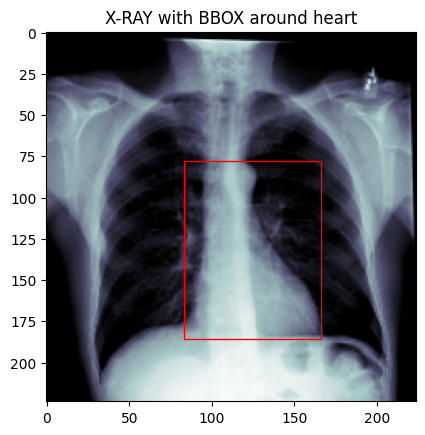

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img, bbox = dataset[0]

fig, axis = plt.subplots(1, 1)

axis.imshow(img_np, cmap="bone")
rect = patches.Rectangle((bbox_np[0], bbox_np[1]), bbox_np[2]-bbox_np[0], bbox_np[3]-bbox_np[1], 
                        edgecolor="r", facecolor="none")
axis.add_patch(rect)
axis.set_title("X-RAY with BBOX around heart")
print(bbox)


In [10]:
# Test basic functionality
print(f"Dataset length: {len(dataset)}")
img, bbox = dataset[0]
print(f"Image shape: {img.shape}")
print(f"Image dtype: {img.dtype}")
print(f"Image value range: [{img.min():.3f}, {img.max():.3f}]")
print(f"Bbox: {bbox}")
print(f"Bbox shape: {bbox.shape}")

Dataset length: 400
Image shape: torch.Size([1, 224, 224])
Image dtype: torch.float32
Image value range: [-1.960, 2.008]
Bbox: tensor([ 77.0482,  61.3483, 163.9727, 170.7072])
Bbox shape: torch.Size([4])


In [11]:
def check_raw_image(idx=0):
    # Temporarily get raw image (before normalization in your dataset)
    patient = dataset.patients[idx]
    data = dataset.labels[dataset.labels["name"] == patient]
    
    file_path = dataset.root_path / patient
    raw_img = np.load(f"{file_path}.npy").astype(np.float32)
    
    print(f"Raw image shape: {raw_img.shape}")
    print(f"Raw image range: [{raw_img.min():.3f}, {raw_img.max():.3f}]")
    print(f"Raw image mean: {raw_img.mean():.3f}")
    print(f"Raw image std: {raw_img.std():.3f}")
    
    return raw_img

raw_img = check_raw_image(0)

Raw image shape: (224, 224)
Raw image range: [0.000, 0.949]
Raw image mean: 0.433
Raw image std: 0.271


Sample 0:
  Original bbox:  [91.0, 71.0, 168.0, 173.0]
  Augmented bbox: [92.0, 75.4, 165.9, 187.5]
  Bbox shift: dx=1.0, dy=4.4

Sample 1:
  Original bbox:  [70.0, 64.0, 159.0, 131.0]
  Augmented bbox: [57.9, 53.3, 163.9, 147.9]
  Bbox shift: dx=-12.1, dy=-10.7

Sample 2:
  Original bbox:  [82.0, 55.0, 163.0, 131.0]
  Augmented bbox: [73.3, 55.8, 152.1, 137.7]
  Bbox shift: dx=-8.7, dy=0.8

Sample 3:
  Original bbox:  [93.0, 74.0, 171.0, 163.0]
  Augmented bbox: [98.2, 71.9, 186.5, 177.9]
  Bbox shift: dx=5.2, dy=-2.1

Sample 4:
  Original bbox:  [85.0, 61.0, 170.0, 154.0]
  Augmented bbox: [75.8, 53.1, 160.9, 144.5]
  Bbox shift: dx=-9.2, dy=-7.9

Sample 5:
  Original bbox:  [63.0, 60.0, 163.0, 145.0]
  Augmented bbox: [74.3, 52.8, 158.1, 144.2]
  Bbox shift: dx=11.3, dy=-7.2



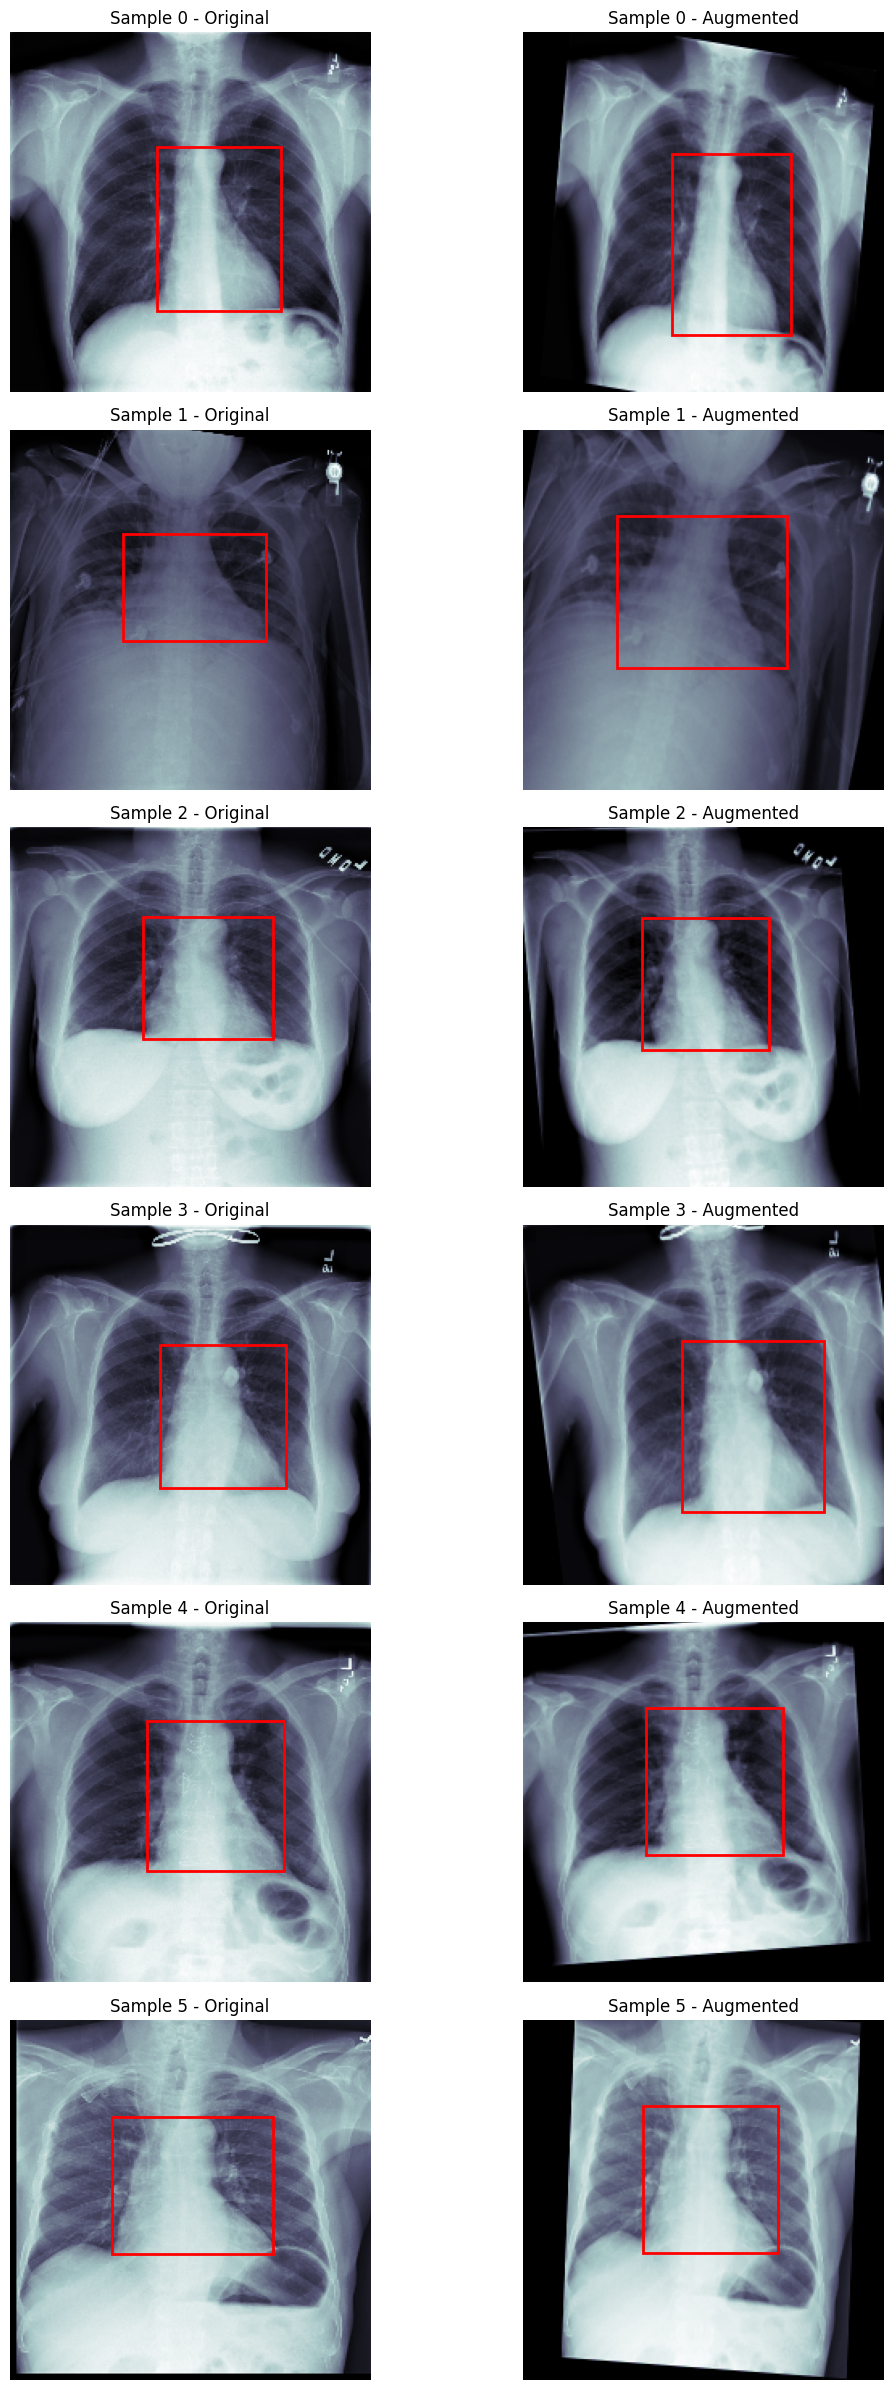

In [14]:
dataset_no_aug = CardiacDataset(labels_path, patients_path, train_root, augs=None)

# Compare same image with and without augmentation side by side
def compare_augmentation_side_by_side(dataset_with_aug, dataset_no_aug, num_samples=6):
    """Compare multiple samples with and without augmentation"""
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))
    
    for i in range(num_samples):
        # Without augmentation (left column)
        img_orig, bbox_orig = dataset_no_aug[i]
        img_orig_np = img_orig[0].numpy()
        
        axes[i, 0].imshow(img_orig_np, cmap="bone")
        rect_orig = patches.Rectangle((bbox_orig[0], bbox_orig[1]), 
                                    bbox_orig[2]-bbox_orig[0], bbox_orig[3]-bbox_orig[1], 
                                    edgecolor="red", facecolor="none", linewidth=2)
        axes[i, 0].add_patch(rect_orig)
        axes[i, 0].set_title(f"Sample {i} - Original")
        axes[i, 0].axis('off')
        
        # With augmentation (right column)
        img_aug, bbox_aug = dataset_with_aug[i]
        img_aug_np = img_aug[0].numpy()
        
        axes[i, 1].imshow(img_aug_np, cmap="bone")
        rect_aug = patches.Rectangle((bbox_aug[0], bbox_aug[1]), 
                                   bbox_aug[2]-bbox_aug[0], bbox_aug[3]-bbox_aug[1], 
                                   edgecolor="red", facecolor="none", linewidth=2)
        axes[i, 1].add_patch(rect_aug)
        axes[i, 1].set_title(f"Sample {i} - Augmented")
        axes[i, 1].axis('off')
        
        # Print bbox info for comparison
        print(f"Sample {i}:")
        print(f"  Original bbox:  [{bbox_orig[0]:.1f}, {bbox_orig[1]:.1f}, {bbox_orig[2]:.1f}, {bbox_orig[3]:.1f}]")
        print(f"  Augmented bbox: [{bbox_aug[0]:.1f}, {bbox_aug[1]:.1f}, {bbox_aug[2]:.1f}, {bbox_aug[3]:.1f}]")
        print(f"  Bbox shift: dx={bbox_aug[0]-bbox_orig[0]:.1f}, dy={bbox_aug[1]-bbox_orig[1]:.1f}\n")
    
    plt.tight_layout()
    plt.show()



# Compare first 6 samples
compare_augmentation_side_by_side(dataset, dataset_no_aug, num_samples=6)
